Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


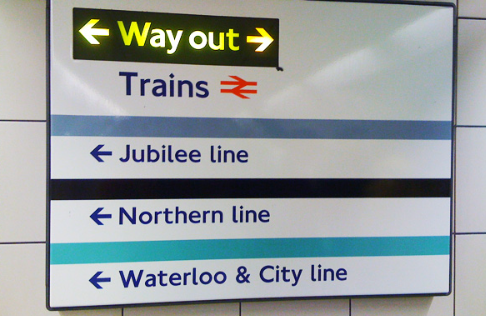

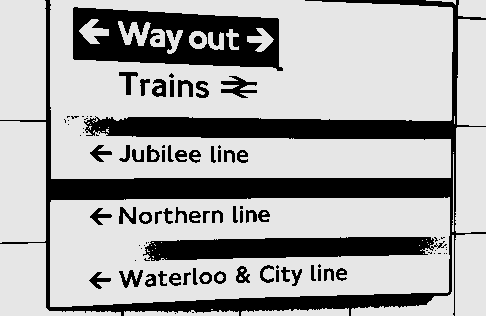

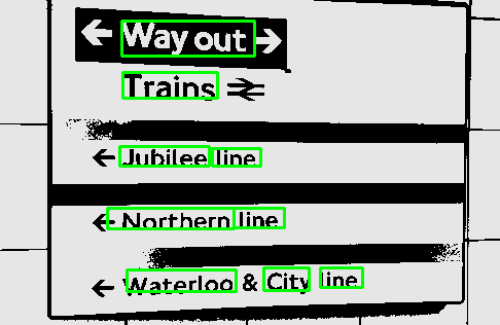

---------------------
 
   
   
   
   

Trains =
€ Jubilee line
€ Northern line

€ Waterloo & City line

--------------------
---------------------
['Way out Trains', 'Jubilee line', 'Northern line', 'Waterloo City line']
--------------------


In [5]:
# install some package for my project
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install easyocr

# import some package for supporting my project
import cv2
import numpy as np
import argparse
import time
import imutils
import pytesseract
import easyocr
from google.colab import drive
from google.colab.patches import cv2_imshow
from imutils.object_detection import non_max_suppression

# mount the directory into my project
drive.mount("/content/drive")

# using the package of cv2 to open the image and the package of google.colab to show it
image = cv2.imread("/content/drive/MyDrive/image_test2.png")
cv2_imshow(image)

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply necessary image processing techniques threshold and save it become a new image.
threshold, thresh = cv2.threshold(gray_image, 125, 230, cv2.THRESH_BINARY)
cv2.imwrite('/content/drive/MyDrive/image2.png', thresh)
cv2_imshow(thresh)

# begin to use the EAST text detector to detect the text and draw the boxes
# load the image
image = cv2.imread("/content/drive/MyDrive/image2.png")
orig = image.copy()

# get the size of image
H, W = image.shape[:2]

# define the size of the image
(newW, newH) = (320, 320)
# calculate scaling ratio
rW = W / float(newW)
rH = H / float(newH)

# resize the image and get the size
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]

# define the port for model output
layerNames = [
    "feature_fusion/Conv_7/Sigmoid",
    "feature_fusion/concat_3"]

# load the EAST text detector model
net = cv2.dnn.readNet("/content/drive/MyDrive/frozen_east_text_detection.pb")

# convert the input image into a format suitable for neural network model
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H), (123.68, 116.78, 103.94), swapRB=True, crop=False)

# send it to model for handling
net.setInput(blob)
# obtain dense sampling result
(scores, geometry) = net.forward(layerNames)

# extract the dense sampling result
(numRows, numCols) = scores.shape[2:4]
# storage detection area
rects = []
# storage the confidence level of detection area
confidences = []

for y in range(0, numRows):
    # obtain regional information
    scoresData = scores[0, 0, y]
    xData0 = geometry[0, 0, y]
    xData1 = geometry[0, 1, y]
    xData2 = geometry[0, 2, y]
    xData3 = geometry[0, 3, y]
    anglesData = geometry[0, 4, y]

    for x in range(0, numCols):
        # if the confident level is low, not to handle
        if scoresData[x] < 0.5:
            continue

        # calculate the center offset
        (offsetX, offsetY) = (x * 4.0, y * 4.0)

        # get the angle and compute the cos and sin
        angle = anglesData[x]
        cos = np.cos(angle)
        sin = np.sin(angle)

        # calculate the height and width about rigion
        h = xData0[x] + xData2[x]
        w = xData1[x] + xData3[x]

        # calculate the coordinate
        endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
        endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
        startX = int(endX - w)
        startY = int(endY - h)

        # add the bounding box coordinate
        rects.append((startX, startY, endX, endY))
        confidences.append(scoresData[x])

boxes = non_max_suppression(np.array(rects), probs=confidences)

# draw the result
for i, (startX, startY, endX, endY) in enumerate(boxes):
    startX = int(startX * rW)
    startY = int(startY * rH)
    endX = int(endX * rW)
    endY = int(endY * rH)

    cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)

# show the result image and save it
cv2_imshow(imutils.resize(orig,width=500))
cv2.imwrite('/content/drive/MyDrive/image3.png', imutils.resize(orig,width=500))

# load the image is handled by the processing techniques
img = cv2.imread('/content/drive/MyDrive/image2.png')
text = pytesseract.image_to_string(img, lang="eng") # extract the text in english


print("---------------------")
print(text)
print("--------------------")

# use the package of easyocr to extract the text from the image
reader = easyocr.Reader(['en'])
result = reader.readtext("/content/drive/MyDrive/image2.png", detail = 0, paragraph = True)
print("---------------------")
print(result)
print("--------------------")

